# Iteration 1: A simple model with one type of unplanned admission

In order to simplify the model, we will first assume that patients only arrive from A&E.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import simpy
from sim_tools.distributions import Exponential, Lognormal

## Model Classes

We will use the structure for healthcare modelling in SimPy recommended in the [HSMA little book of DES](https://des.hsma.co.uk/). This is an object orientated approach which makes use of four classes:

* `g`, a class for storing global parameters for the model (no instance will be created of this class, which is why we use a lower case name).
* `Patient`, a class used to store information about the patients in the system.
* `Model`, a class representing the overall system, in which the SimPy environment and generators are kept.
* `Trial`, a class representing a batch of runs of a simulation. 

### The `g` class

Let's start by coding a simple version of the `g` class for our CCU model.

In [2]:
class g:
    mean_interarrival = 22.72
    mean_len_stay = 128.79
    stdev_len_stay = 267.51
    number_of_beds = 5
    sim_duration = 2016
    warm_up_period = 672
    number_of_reps = 10

### The `Patient` class

Now we code a class representing patients who are admitted to the unit.

In [3]:
class Patient:
    def __init__(self, p_id):
        self.id = p_id
        self.queue_time = 0
        self.time_in_ccu = 0

### The `Model` class

We now move on to the `Model` class.

In [4]:
class Model:
    def __init__(self, run_number):
        self.env = simpy.Environment()
        self.patient_counter = 0
        self.sim_pt_objects = []
        self.bed = simpy.Resource(self.env, capacity=g.number_of_beds)
        self.run_number = run_number
        self.results_df = pd.DataFrame()
        self.results_df["Patient ID"] = [1]
        self.results_df["Queue Time"] = [0.0]
        self.results_df["Length of Stay"] = [0.0]
        self.results_df.set_index("Patient ID", inplace=True)
        self.mean_queue_time = 0
        self.bed_utilisation = 0.0
        ss = np.random.SeedSequence(self.run_number)
        seeds = ss.spawn(2)
        self.inter_arrival_dist = Exponential(mean=g.mean_interarrival,
                                              random_seed=seeds[0])
        self.len_stay_dist = Lognormal(mean=g.mean_len_stay,
                                       stdev=g.stdev_len_stay,
                                       random_seed=seeds[1])
    def generator_patient_arrivals(self):
        while True:
            self.patient_counter += 1
            p = Patient(self.patient_counter)
            self.env.process(self.admit_unit(p))
            sampled_inter = self.inter_arrival_dist.sample()
            yield self.env.timeout(sampled_inter)
    def admit_unit(self, patient):
        referral_time = self.env.now
        start_q_bed = self.env.now
        with self.bed.request() as req:
            yield req
            end_q_bed = self.env.now
            patient.queue_time = end_q_bed - start_q_bed
            sampled_len_stay = self.len_stay_dist.sample()
            sim_time_remain = g.sim_duration + g.warm_up_period - self.env.now
            len_stay_before_end_sim = min(sampled_len_stay, sim_time_remain)
            patient.time_in_ccu = len_stay_before_end_sim
            if self.env.now > g.warm_up_period:
                self.results_df.at[patient.id, "Queue Time"] = (
                    patient.queue_time)
                self.results_df.at[patient.id, "Length of Stay"] = (
                    sampled_len_stay)
                self.sim_pt_objects.append(patient)
            yield self.env.timeout(sampled_len_stay)
    def audit_bed_utilisation(self):
        treatment_durations = [i.time_in_ccu for i in self.sim_pt_objects]
        return (sum(treatment_durations) / (g.number_of_beds
                                            *g.sim_duration))
    def calculate_run_results(self):
        self.results_df.drop([1], inplace=True)
        first_patient_post_warm_up = min(self.results_df.index)
        self.mean_queue_time = self.results_df["Queue Time"].mean()
        self.mean_len_stay = self.results_df["Length of Stay"].mean()
        self.bed_utilisation = self.audit_bed_utilisation()
    def run(self):
        self.env.process(self.generator_patient_arrivals())
        self.env.run(until=(g.sim_duration + g.warm_up_period))
        self.calculate_run_results()

### The `Trial` class

Finally, we implement a simple `Trial` class.

In [5]:
class Trial:
    def __init__(self):
        self.run_results_dict = {}
        self.event_logs_dict = {}
        self.trial_results_df = pd.DataFrame()
        self.trial_results_df["Run Number"] = [0]
        self.trial_results_df["Mean Queue Time"] = [0.0]
        self.trial_results_df["Average Bed Utilisation"] = [0.0]
        self.trial_results_df.set_index("Run Number", inplace=True)
    def print_trial_results(self):
        print ("Trial Results")
        print (self.trial_results_df)
    def run_trial(self):
        for run in range(g.number_of_reps):
            ccu_model = Model(run)
            ccu_model.run()
            run_results = ccu_model.results_df
            self.run_results_dict[f"Run {run}"] = run_results
            self.trial_results_df.loc[run,
                "Mean Queue Time"] = [ccu_model.mean_queue_time]
            self.trial_results_df.loc[run,
                "Average Bed Utilisation"] = [ccu_model.bed_utilisation]

## Running the Model and Exploring the Results

In [6]:
my_trial = Trial()
my_trial.run_trial()
trial_results = my_trial.trial_results_df
trial_results

,Mean Queue Time,Average Bed Utilisation
Run Number,,
0,14.194327,0.797401
1,38.445913,0.677624
2,110.953630,0.731474
3,64.891236,0.844703
4,502.120927,0.896885
5,230.658429,0.813590
6,257.044442,0.954491
7,254.208347,0.691494
8,486.880047,0.851095


In [7]:
run_0_results = my_trial.run_results_dict["Run 0"]
run_0_results.head(20)

,Queue Time,Length of Stay
Patient ID,,
25,0.000000,734.437760
26,0.000000,25.658144
27,0.000000,86.780475
28,10.656938,17.463928
29,19.247210,87.199474
30,38.392894,21.078560
31,15.185604,59.932651
32,0.000000,119.298750
33,2.138585,60.263865


In [8]:
all_run_results_dict = my_trial.run_results_dict
all_reps = pd.concat(all_run_results_dict.values())
all_reps

,Queue Time,Length of Stay
Patient ID,,
25,0.000000,734.437760
26,0.000000,25.658144
27,0.000000,86.780475
28,10.656938,17.463928
29,19.247210,87.199474
...,...,...
125,39.501365,75.911554
126,26.779426,7.133693
127,21.008201,12.765987


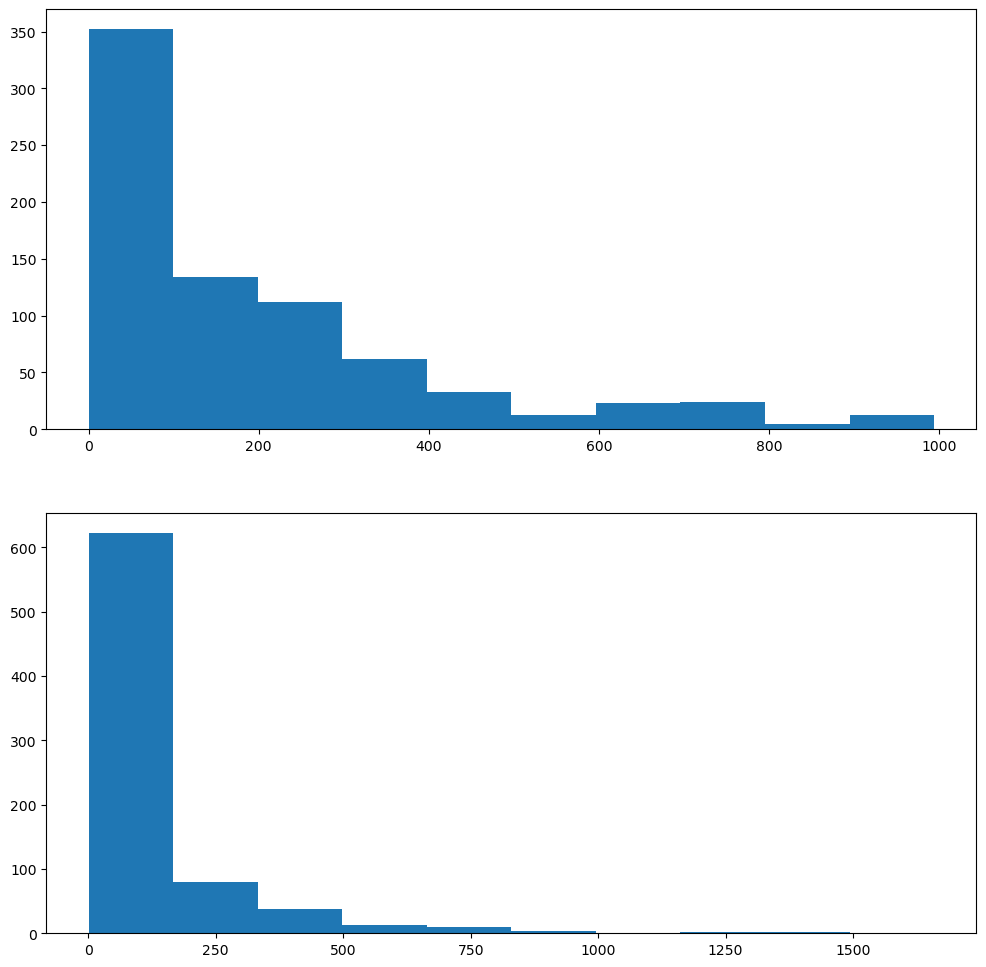

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(12,12))
ax[0].hist(all_reps["Queue Time"]);
ax[1].hist(all_reps["Length of Stay"]);